In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import numpy as np


/Users/bling/opt/anaconda3/envs/cv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bling/opt/anaconda3/envs/cv/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <DDABACEB-F2EA-368C-80DD-40745DFB96F8> /Users/bling/opt/anaconda3/envs/cv/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <C06D85DA-0769-3311-A69C-B6FBFB1FAC59> /Users/bling/opt/anaconda3/envs/cv/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=False
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
)

print(train_data)

AttributeError: module 'torch' has no attribute '_six'

In [3]:
from torch.utils.data import DataLoader
loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

loaders

NameError: name 'train_data' is not defined

In [ ]:
from model import ResNet, Basicblock, Bottleneck
from torch import optim

# model = ResNet(Basicblock, 1, [1, 1, 1, 1], 10)
model = ResNet(Bottleneck, 1, [1, 1, 1, 1], 10)
print(model)
loss_func = nn.CrossEntropyLoss()

In [ ]:
optim_sgd = optim.SGD(model.parameters(), lr=0.1, momentum=0.05)
optim = optim_sgd

In [ ]:
num_epochs = 5

loss_array = []

def train(num_epochs, model, loaders, optimizer, loss_arr):
    print('* Start Training *...')
    model.train()
    total_steps = len(loaders['train'])
    loss_per_100 = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            X = images.to(device)
            y = labels.to(device)

            pred = model(X)
            criterion = loss_func(pred, y)

            pred_label = torch.max(pred, 1)[1].data.squeeze() # labels are from 1 to 10, minimum value is 1

            optimizer.zero_grad()
            criterion.backward()
            optimizer.step()

            loss_per_100.append(criterion.detach().numpy())
            if (i + 1) % 100 == 0:
                loss = sum(loss_per_100) / len(loss_per_100)
                loss_arr.append(loss)
                loss_per_100 = []
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: [{}/{}]'
                       .format(epoch + 1, num_epochs, i + 1, total_steps, criterion, (pred_label == labels).sum(), len(pred))) # len(pred) == 100
            pass
        pass
    pass


In [ ]:
train(num_epochs, model, loaders, optim, loss_array)

In [8]:
len(loss_array)

30

<function matplotlib.pyplot.legend(*args, **kwargs)>

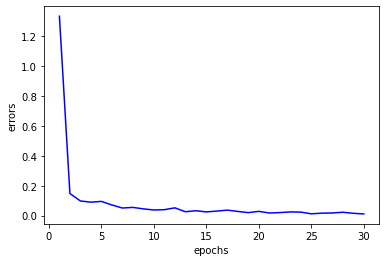

In [9]:
import matplotlib.pyplot as plt

x_range = np.linspace(start=1, stop=30, num=30)
plt.figure()
plt.xlabel('epochs')
plt.ylabel('errors')
plt.plot(x_range, loss_array, color = 'blue')
# plt.plot(x_range, loss_arr_2, color = 'red')
plt.legend